In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Nếu không sử dụng encoding='latin1', việc đọc file CSV có thể gặp lỗi nếu file này chứa các ký tự không nằm trong bộ mã mặc định (thường là UTF-8).

#Đọc dữ liệu vào

In [3]:
df = pd.read_csv('/content/drive/MyDrive/KLTN/TextData/spam.csv', encoding='latin1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [7]:
df.rename(columns = {'v1': 'target', 'v2': 'text'}, inplace = True)

In [8]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#Mã hóa cột target

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [10]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#Kiểm tra giá trị null

In [11]:
df.isnull().sum()

,0
target,0
text,0


#Kiểm tra dữ liệu trùng

In [12]:
df.duplicated().sum()

403

In [13]:
df = df.drop_duplicates(keep = 'first')

In [14]:
df.duplicated().sum()

0

In [15]:
df.shape

(5169, 2)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5169 non-null   int64 
 1   text    5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


#Percentage of Ham and Spam

In [17]:
values = df['target'].value_counts()
total = values.sum()

percentage_0 = (values[0] /total) * 100
percentage_1 = (values[1]/ total) *100

print('percentage of 0 :' ,percentage_0)
print('percentage of 1 :' ,percentage_1)

percentage of 0 : 87.3669955503966
percentage of 1 : 12.633004449603405


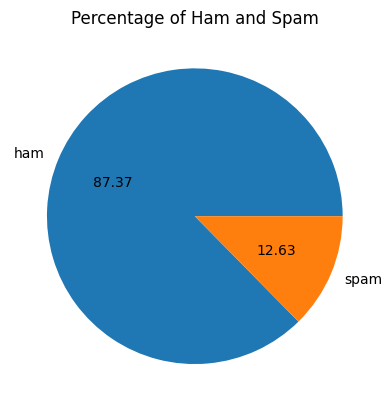

In [18]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels = ['ham', 'spam'], autopct = '%0.2f')
plt.title('Percentage of Ham and Spam')
plt.show()

Như bạn thấy trên biểu đồ, tỷ lệ ham quá cao (87,37%) so với tỷ lệ tin nhắn rác. vậy là dữ liệu mất cân bằng

#Chuẩn hóa dữ liệu

In [19]:
import spacy
import re
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

df['transformed_text']=df['text'].apply(lambda x:expand_contractions(x))

In [20]:
df.head()

,target,text,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","Nah I do not think he goes to usf, he lives ar..."


In [21]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import nltk
import string

# Tải các tài nguyên cần thiết
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

NLTK

In [22]:
# Hàm để lấy nhãn loại từ cho lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

# Hàm transform_text
def transform_text(text):
    # Biến đổi văn bản thành chữ thường
    text = text.lower()
    # Tokenization sử dụng NLTK
    text = nltk.word_tokenize(text)
    # Loại bỏ ký tự đặc biệt
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    # Duyệt qua các token và loại bỏ stopwords và dấu câu
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    # Lemmatization sử dụng WordNet Lemmatizer
    text = y[:]
    y.clear()
    for i in text:
        pos = get_wordnet_pos(i)
        print(f"Word: {i}, POS: {pos}")  # Thêm dòng này để in ra POS tag
        y.append(lemmatizer.lemmatize(i, pos))
    # Ghép các token đã xử lý thành một chuỗi
    return " ".join(y)

print(transform_text('Ok lar... Joking wif u oni...123'))

Word: ok, POS: n
Word: lar, POS: n
Word: joking, POS: n
Word: wif, POS: n
Word: u, POS: n
Word: oni, POS: n
Word: 123, POS: n
ok lar joking wif u oni 123


Spacy

In [23]:
# Tải mô hình ngôn ngữ tiếng Anh của SpaCy
nlp = spacy.load('en_core_web_sm')

# Hàm transform_text sử dụng SpaCy
def transform_text(text):
    # Biến đổi văn bản thành chữ thường
    text = text.lower()
    # Loại bỏ các ký tự đặc biệt
    text = re.sub(r'\b(?:lt|gt)\b', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenization và POS tagging sử dụng SpaCy
    doc = nlp(text)
    # Loại bỏ stopwords và lemmatization
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    # Kiểm tra lại các từ dừng bổ sung
    tokens = [word for word in tokens if word not in nlp.Defaults.stop_words]
    # Ghép các token đã xử lý thành một chuỗi
    return " ".join(tokens)

print(transform_text('Ok lar... Joking wif u oni...123'))

ok lar joke wif u oni 123


In [24]:
df['transformed_text'] = df['transformed_text'].apply(transform_text)

In [25]:
df.head()

,target,text,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


#Word Cloud for Spam Messages

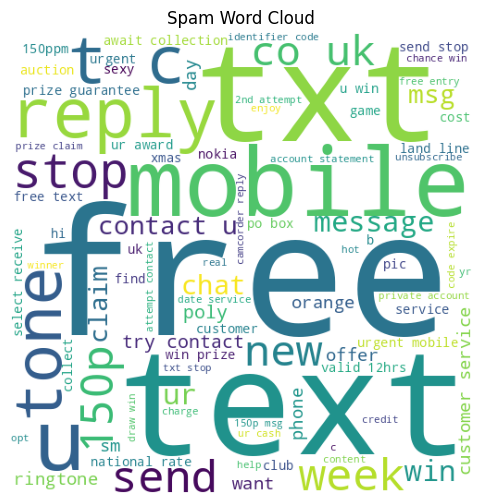

In [26]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.axis('off')
plt.title('Spam Word Cloud')
plt.show()

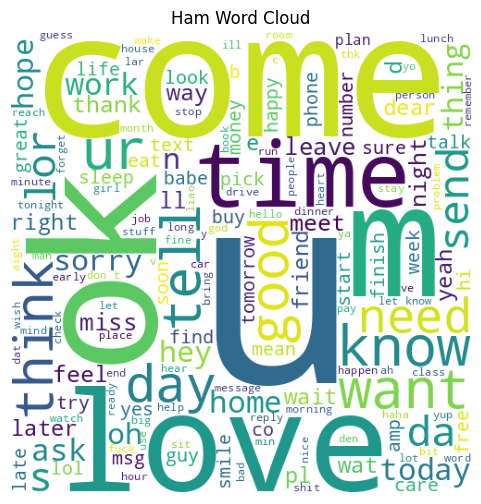

In [27]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(ham_wc)
plt.axis('off')
plt.title('Ham Word Cloud')
plt.show()

#Ngrams

In [28]:
from nltk.tokenize import word_tokenize
df['cleaned_token'] = df['transformed_text'].apply(word_tokenize)

In [29]:
def extract_ngrams(tokenized_data, n):
    ngrams_list = list(nltk.ngrams(tokenized_data, n))
    ngrams_str = [' '.join(grams) for grams in ngrams_list]
    return ngrams_str

#trigrams
df['cleaned_token'] = df['cleaned_token'].apply(lambda x: extract_ngrams(x, 3))

In [30]:
def combine_words(word_list):
    all_words = []
    for word in word_list:
        all_words += word
    return all_words

reviews = df['cleaned_token']
reviews_words = combine_words(reviews)

In [31]:
def count_topwords(all_words):
    counts = dict()
    for word in all_words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    word_count = pd.DataFrame([counts])
    word_count_transposed = word_count.T.reset_index()
    word_count_transposed.columns = ['words', 'word_count']
    word_count_sorted = word_count_transposed.sort_values("word_count", ascending=False)
    return word_count_sorted[:10]

reviews_topword_count = count_topwords(reviews_words)
reviews_topword_count

,words,word_count
5194,u wan 2,21
4626,happy new year,17
3254,2003 account statement,13
3253,private 2003 account,13
150,t c www,13
2634,land line claim,12
3261,s m point,12
2214,suite342 2land row,12
3258,800 un redeem,12
3259,un redeem s,12


#Vector hóa dữ liệu TfidfVectorizer

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(max_features= 3000)

In [33]:
X = tfid.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [34]:
X.shape

(5169, 3000)

In [35]:
y.shape

(5169,)

#Model Building

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [37]:
svc = SVC(kernel='linear', class_weight='balanced')
mnb = MultinomialNB()
lrc = LogisticRegression(random_state = 42, class_weight='balanced')
rfc = RandomForestClassifier(class_weight='balanced',
                             n_estimators = 50, random_state = 42 )

In [38]:
classifiers = {
    'SVC': svc,
    'NB': mnb,
    'LR': lrc,
    'RF': rfc
}

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import  classification_report
import time

Evaluating SVC...
Time taken: 233.32 seconds
Accuracy: 0.9760 ± 0.0015
Precision: 0.9320 ± 0.0158
Recall: 0.8745 ± 0.0212
F1 Score: 0.9020 ± 0.0070



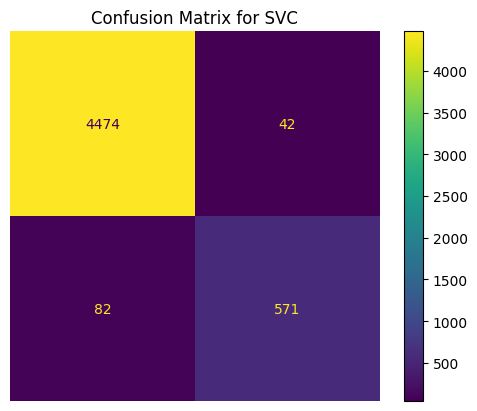

Classification Report for SVC:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4516
           1       0.93      0.87      0.90       653

    accuracy                           0.98      5169
   macro avg       0.96      0.93      0.94      5169
weighted avg       0.98      0.98      0.98      5169


Evaluating NB...
Time taken: 1.99 seconds
Accuracy: 0.9752 ± 0.0050
Precision: 0.9908 ± 0.0142
Recall: 0.8117 ± 0.0367
F1 Score: 0.8919 ± 0.0231



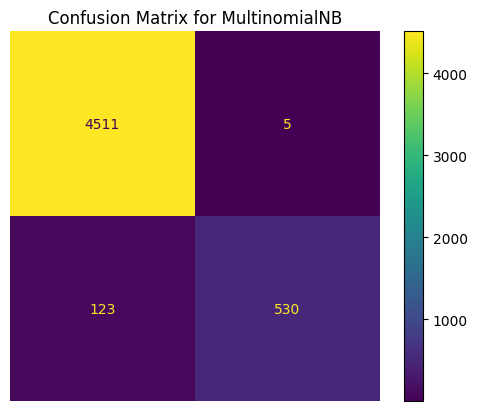

Classification Report for MultinomialNB:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      4516
           1       0.99      0.81      0.89       653

    accuracy                           0.98      5169
   macro avg       0.98      0.91      0.94      5169
weighted avg       0.98      0.98      0.97      5169


Evaluating LR...
Time taken: 14.09 seconds
Accuracy: 0.9754 ± 0.0020
Precision: 0.9156 ± 0.0226
Recall: 0.8882 ± 0.0141
F1 Score: 0.9014 ± 0.0072



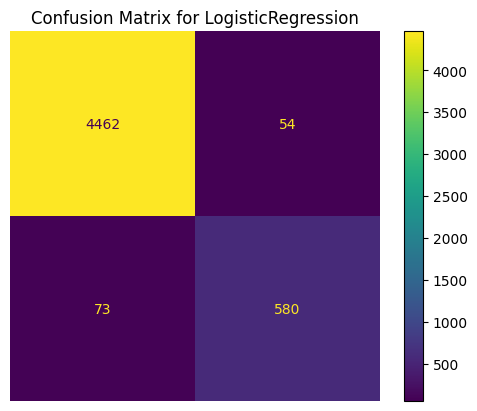

Classification Report for LogisticRegression:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4516
           1       0.91      0.89      0.90       653

    accuracy                           0.98      5169
   macro avg       0.95      0.94      0.94      5169
weighted avg       0.98      0.98      0.98      5169


Evaluating RF...
Time taken: 101.63 seconds
Accuracy: 0.9758 ± 0.0032
Precision: 0.9817 ± 0.0081
Recall: 0.8239 ± 0.0218
F1 Score: 0.8958 ± 0.0144



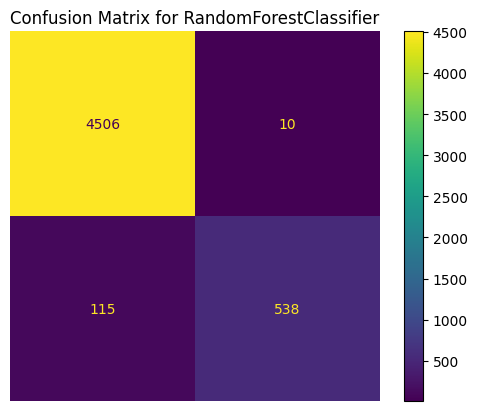

Classification Report for RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4516
           1       0.98      0.82      0.90       653

    accuracy                           0.98      5169
   macro avg       0.98      0.91      0.94      5169
weighted avg       0.98      0.98      0.97      5169




In [40]:
def cross_val_evaluate(classifiers, X, y, cv=5):
    for name, clf in classifiers.items():
        print(f"Evaluating {name}...")

        start_time = time.time()

        # Sử dụng cross_val_score để đánh giá mô hình
        accuracy_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        precision_scores = cross_val_score(clf, X, y, cv=cv, scoring='precision')
        recall_scores = cross_val_score(clf, X, y, cv=cv, scoring='recall')
        f1_scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')

        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Time taken: {elapsed_time:.2f} seconds")
        print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
        print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
        print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
        print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
        print()

        # Sử dụng cross_val_predict để tạo dự đoán
        y_pred = cross_val_predict(clf, X, y, cv=cv)

        # Hiển thị ma trận nhầm lẫn
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix for {clf.__class__.__name__}')
        plt.axis('off')
        plt.show()

        # Hiển thị báo cáo phân loại
        report = classification_report(y, y_pred)
        print(f'Classification Report for {clf.__class__.__name__}:\n', report)
        print()

cross_val_evaluate(classifiers, X, y, cv=5)